<a href="https://colab.research.google.com/github/PavelStelmakhV/hw310-keras-fasion-mnist/blob/main/keras_fasion_mnist_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [255]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tf_keras

from keras import layers
from keras import regularizers
from keras import callbacks
from keras import initializers
from keras.layers import BatchNormalization
from keras.models import load_model

In [256]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [257]:
# create validation data
val_size = 6000

x_val = x_train[-val_size:, :, :]
x_train = x_train[:-val_size, :, :]

y_val = y_train[-val_size:]
y_train = y_train[:-val_size]

In [258]:
# mirror train image
x_train_add = np.rot90(x_train, k=1, axes=(1,2))
x_train_add = np.transpose(x_train_add, (0, 2, 1))

In [259]:
y_train_add = y_train.copy()

In [260]:
# remove boots image from addition data [5, 7, 9]
for i in [5, 7, 9]:
    index = np.where(y_train_add == i )
    x_train_add = np.delete(x_train_add, index , axis=0)
    y_train_add = np.delete(y_train_add, index , axis=0)

In [261]:
x_train_add.shape

(37765, 28, 28)

In [262]:
y_train_add.shape

(37765,)

In [263]:
x_train = np.concatenate([
    x_train,
    x_train_add
])

In [264]:
y_train = np.concatenate([
    y_train,
    y_train_add
])

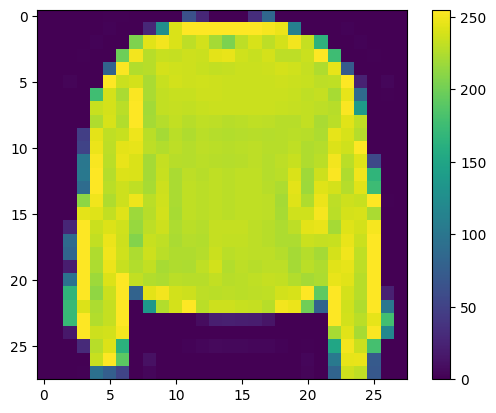

In [265]:
plt.figure()
plt.imshow(x_train[7])
plt.colorbar()
plt.grid(False)
plt.show()

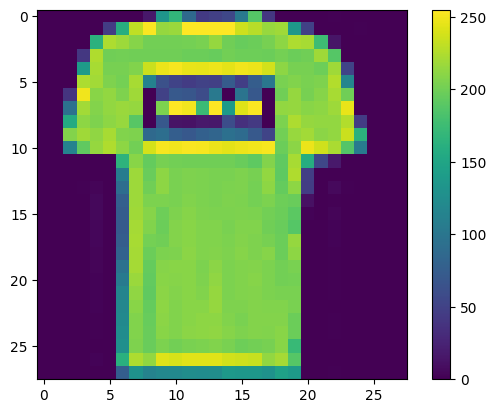

In [266]:
plt.figure()
plt.imshow(x_train_add[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [267]:
y_train[0]

9

In [268]:
y_train[50002]

1

In [269]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

x_val = x_val.astype('float32') / 255
y_val = y_val.astype('float32')

In [270]:
w_init_tanh = initializers.glorot_normal(seed=111)
# w_init_relu = initializers.HeNormal(seed=66)
w_init_relu = initializers.HeUniform(seed=24)
b_init = initializers.Zeros()

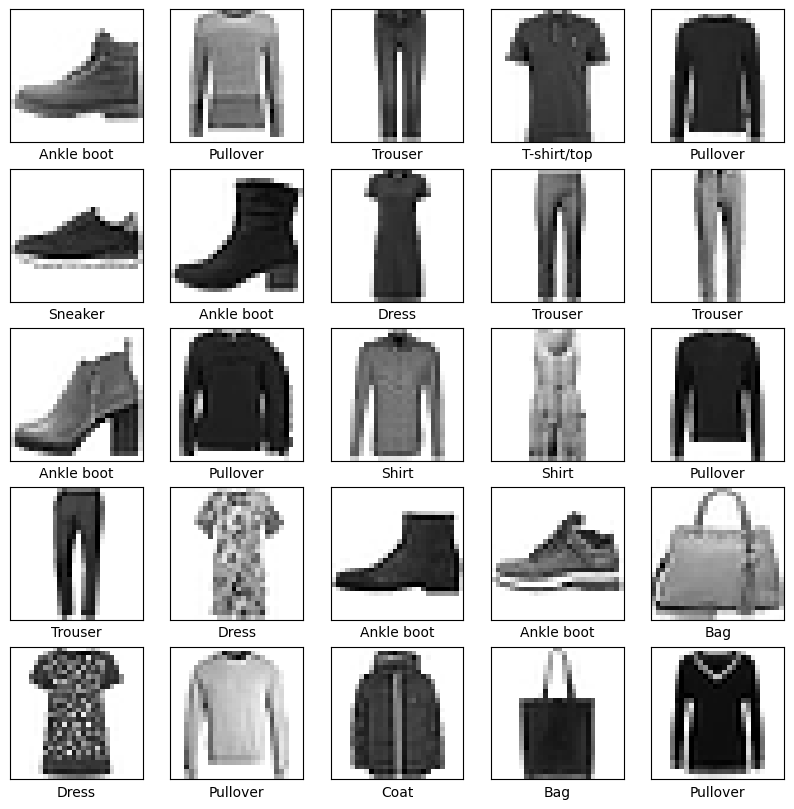

In [271]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i+50000], cmap=plt.cm.binary)
    plt.xlabel(class_names[int(y_train[i+50000])])
plt.show()

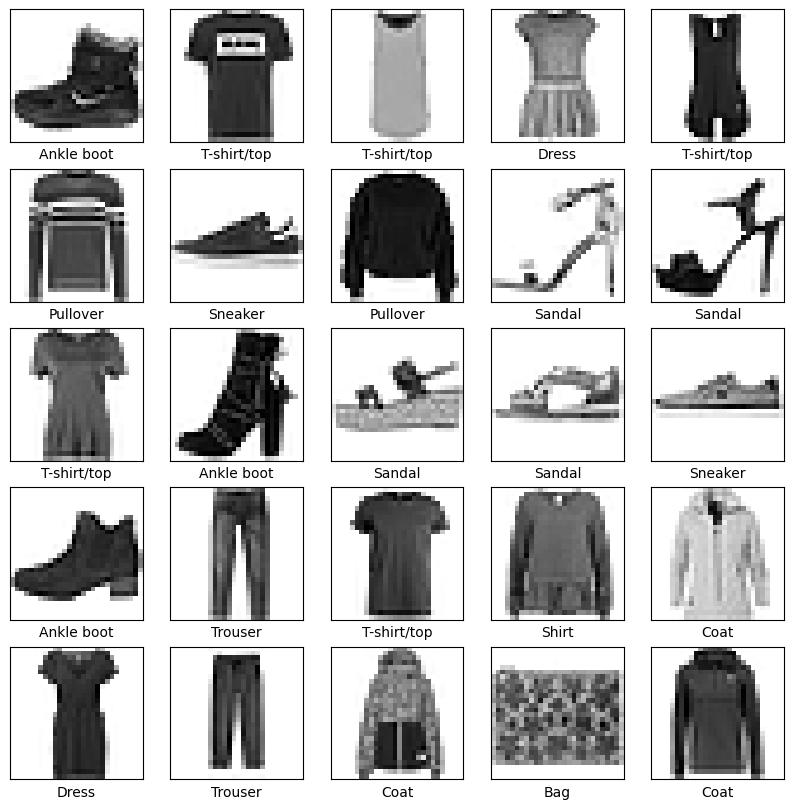

In [272]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[int(y_train[i])])
plt.show()

In [273]:
drop_out = 0.33

In [274]:
def layer_relu(model, neurons):
  model.add(BatchNormalization())
  model.add(layers.Dense(neurons,
                       activation='relu',
                       kernel_initializer=w_init_relu,
                       bias_initializer=b_init))
  model.add(layers.Dropout(drop_out))
  return model

In [275]:
def layer_tanh(model, neurons):
  model.add(BatchNormalization())
  model.add(layers.Dense(neurons,
                        activation='tanh',
                        kernel_initializer=w_init_tanh,
                        bias_initializer=b_init))
  model.add(layers.Dropout(drop_out))
  return model

In [276]:
model = tf.keras.Sequential()

neurons = 256

model.add(layers.Flatten(input_shape=(28, 28)))
model.add(layers.Dropout(drop_out))

model = layer_relu(model, neurons*1)
model = layer_relu(model, neurons*2)
model = layer_relu(model, neurons*2)
# model = layer_relu(model, neurons*1)


model.add(layers.Dense(10, activation='softmax'))

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [277]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.0003,
                                      beta_1=0.92,
                                      beta_2=0.999,
                                      epsilon=1e-04
)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [278]:
model.compile(#optimizer='adam',
              # optimizer='adamax',
              optimizer=optimizer,
              # optimizer='rmsprop',
              # optimizer='sgd',
              # optimizer='adadelta',
              # loss='binary_crossentropy',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']) # sparse_categorical_accuracy

1/1 [==============================] - 0s 124ms/step


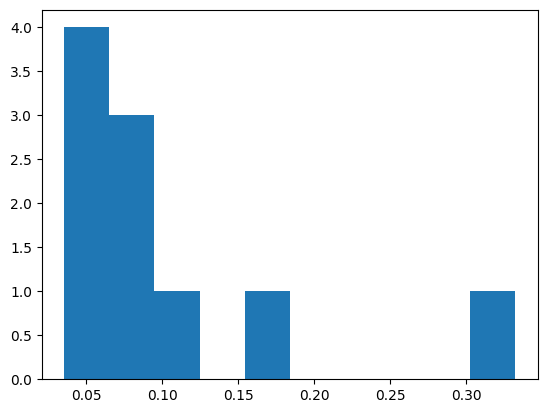

In [279]:
x = np.random.random((1, 28, 28))
a = model.predict(x)
_ = plt.hist(np.transpose(a))

In [280]:
y_pred = model.predict(x_test)

313/313 [==============================] - 1s 3ms/step


In [281]:
callback = callbacks.EarlyStopping(monitor='val_loss',
                                   patience=50,
                                   restore_best_weights=True,
                                   )
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=60)
mc = callbacks.ModelCheckpoint('best_model.h5', monitor='accuracy', mode='max', verbose=0, save_best_only=True)


In [282]:
history = model.fit(x_train, y_train,
                    epochs=700,
                    batch_size=128,
                    # callbacks=[callback],
                    callbacks=[mc],
                    verbose=1, #многословие
                    # validation_split=0.2
                    validation_data=(x_val, y_val)
                    )
test_loss, test_acc = model.evaluate(x_test, y_test)
print('\nTest accuracy:', test_acc)

Epoch 1/700
717/717 [==============================] - 27s 33ms/step - loss: 0.9667 - accuracy: 0.6625 - val_loss: 0.4806 - val_accuracy: 0.8207
Epoch 2/700
717/717 [==============================] - 23s 33ms/step - loss: 0.6512 - accuracy: 0.7632 - val_loss: 0.4340 - val_accuracy: 0.8377
Epoch 3/700
717/717 [==============================] - 16s 23ms/step - loss: 0.5742 - accuracy: 0.7861 - val_loss: 0.4063 - val_accuracy: 0.8503
Epoch 4/700
717/717 [==============================] - 16s 23ms/step - loss: 0.5378 - accuracy: 0.8016 - val_loss: 0.3958 - val_accuracy: 0.8513
Epoch 5/700
717/717 [==============================] - 17s 24ms/step - loss: 0.5093 - accuracy: 0.8095 - val_loss: 0.3756 - val_accuracy: 0.8603
Epoch 6/700
717/717 [==============================] - 17s 23ms/step - loss: 0.4925 - accuracy: 0.8155 - val_loss: 0.3719 - val_accuracy: 0.8628
Epoch 7/700
717/717 [==============================] - 17s 23ms/step - loss: 0.4745 - accuracy: 0.8230 - val_loss: 0.3562 - val_ac

In [283]:
print('\nhistory dict:', list(history.history.keys()))


history dict: ['loss', 'accuracy', 'val_loss', 'val_accuracy']


In [284]:
result = model.evaluate(x_test, y_test)
print(result)

313/313 [==============================] - 1s 3ms/step - loss: 0.2788 - accuracy: 0.9052
[0.2787925899028778, 0.9052000045776367]


In [285]:
saved_model = load_model('best_model.h5')
result = saved_model.evaluate(x_test, y_test)
print(result)

313/313 [==============================] - 1s 3ms/step - loss: 0.2788 - accuracy: 0.9052
[0.2787925899028778, 0.9052000045776367]


In [286]:
# from keras.models import load_model
# saved_model = load_model('best_model.h5')
# # _, train_acc = saved_model.evaluate(x_train, y_train, verbose=0)
# _, test_acc = saved_model.evaluate(x_test, y_test, verbose=0)
# print('Test: %.3f' % (test_acc))

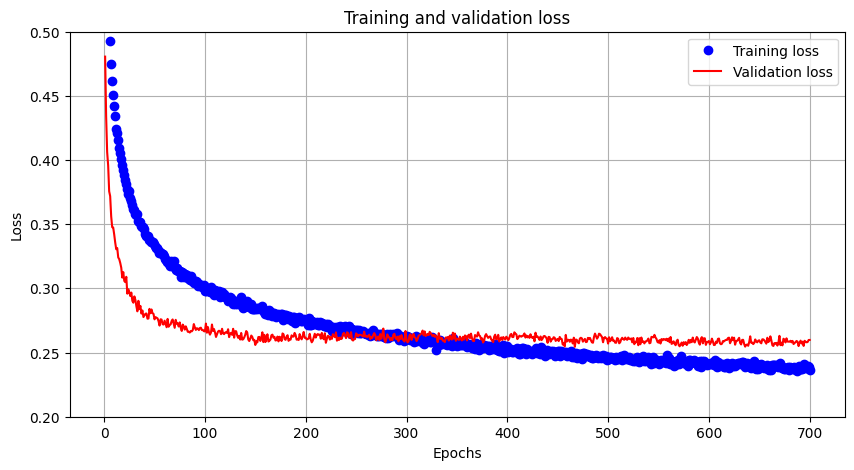

<Figure size 640x480 with 0 Axes>

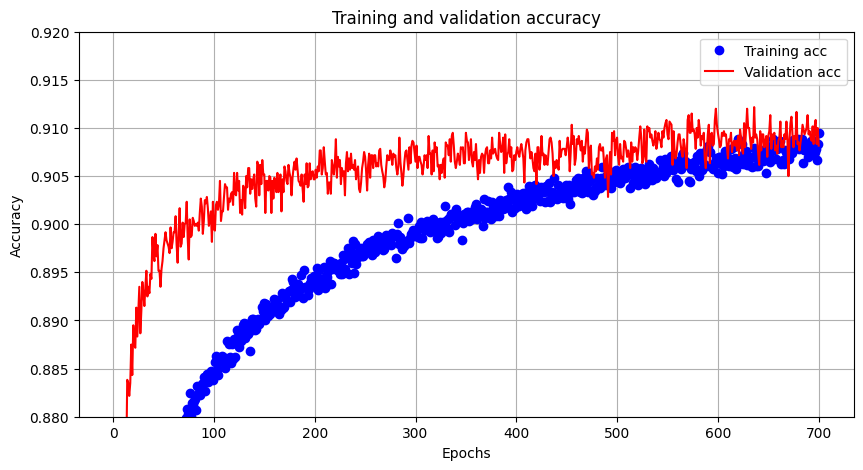

In [287]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['loss']) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.ylim (0.2, 0.5)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
1
plt.clf()
plt.figure(figsize=(10, 5))
val_acc_values = history_dict['accuracy']
plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history_dict['val_accuracy'], 'r', label='Validation acc')
plt.ylim (0.88, 0.92)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

In [288]:
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])

In [289]:
predictions = probability_model.predict(x_test)

313/313 [==============================] - 2s 5ms/step


In [290]:
predictions[0]

array([0.0854184 , 0.0854184 , 0.0854184 , 0.0854184 , 0.0854184 ,
       0.08543136, 0.0854184 , 0.08596794, 0.0854184 , 0.23067197],
      dtype=float32)

In [291]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 dropout_24 (Dropout)        (None, 784)               0         
                                                                 
 batch_normalization_18 (Ba  (None, 784)               3136      
 tchNormalization)                                               
                                                                 
 dense_24 (Dense)            (None, 256)               200960    
                                                                 
 dropout_25 (Dropout)        (None, 256)               0         
                                                                 
 batch_normalization_19 (Ba  (None, 256)               1024      
 tchNormalization)                                    

In [292]:




hnyetjn hrte()

SyntaxError: invalid syntax (<ipython-input-292-1a3818e70946>, line 1)